In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
import os, ast, inspect
from typing import Any, Callable, Dict, List, Optional, Union, Type

from fastcore.all import *
from fastai.callback.all import *
from fastai.data.block import DataBlock, ColReader, ItemGetter, ColSplitter, RandomSplitter
from fastai.data.core import DataLoader, DataLoaders, TfmdDL
from fastai.imports import *
from fastai.learner import *
from fastai.losses import CrossEntropyLossFlat
from fastai.optimizer import Adam, OptimWrapper, params
from fastai.metrics import perplexity
from fastai.torch_core import *
from fastai.torch_imports import *
from fastprogress.fastprogress import progress_bar,master_bar
from sklearn.metrics import accuracy_score
from transformers import (
    AutoModelForCausalLM, AutoModelForMaskedLM, logging,
    PretrainedConfig, PreTrainedTokenizerBase, PreTrainedModel
)


from blurr.utils import BLURR
from blurr.data.core import HF_TextBlock, BlurrDataLoader, first_blurr_tfm
from blurr.modeling.core import HF_PreCalculatedLoss, Blearner
from blurr.data.language_modeling import (
    HF_LMBeforeBatchTransform, LMType, LMStrategy, HF_CausalLMInput, CausalLMStrategy, HF_MLMInput, BertMLMStrategy
)

logging.set_verbosity_error()

In [3]:
#hide_input
import pdb

from fastai.data.external import untar_data, URLs
from fastcore.test import *
from nbverbose.showdoc import show_doc

from blurr.utils import print_versions
from blurr.modeling.core import HF_BaseModelWrapper, HF_BaseModelCallback, HF_PreCalculatedLoss, hf_splitter

os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("What we're running with at the time this documentation was generated:")
print_versions('torch fastai transformers')

What we're running with at the time this documentation was generated:
torch: 1.9.1+cu111
fastai: 2.5.4
transformers: 4.10.2


In [4]:
from ranking_utils import *

In [5]:
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: Tesla V100-PCIE-32GB


In [6]:
path = Path('./data/')

df = pd.read_csv(path/'cord-19_2020-07-16_ta_text.csv', index_col=0)

In [7]:
N = df.shape[0]
valid_pc = 0.2

num_valid = int(N*valid_pc)
valid_idx = np.random.randint(N, size=num_valid)

df['is_valid'] = False
df['is_valid'].iloc[valid_idx] = True

/scratch/cse/phd/anz198717/anaconda3/envs/fasthugs/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [8]:
print(len(df))
df.head()

191175


,corduid,text,is_valid
0,ug7v899j,"Clinical features of culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia OBJECTIVE: This retrospective chart review describes the epidemiology and clinical features of 40 patients with culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia. METHODS: Patients with positive M. pneumoniae cultures from respiratory specimens from January 1997 through December 1998 were identified through the Microbiology records. Charts of patients were reviewed. RESULTS: 40 patients were identified, 33...",False
1,02tnwd4m,"Nitric oxide: a pro-inflammatory mediator in lung disease? Inflammatory diseases of the respiratory tract are commonly associated with elevated production of nitric oxide (NO•) and increased indices of NO• -dependent oxidative stress. Although NO• is known to have anti-microbial, anti-inflammatory and anti-oxidant properties, various lines of evidence support the contribution of NO• to lung injury in several disease models. On the basis of biochemical evidence, it is often presumed that such NO• -dependent oxidations are due to the formation of the oxidant peroxynitrite, although alternati...",False
2,ejv2xln0,"Surfactant protein-D and pulmonary host defense Surfactant protein-D (SP-D) participates in the innate response to inhaled microorganisms and organic antigens, and contributes to immune and inflammatory regulation within the lung. SP-D is synthesized and secreted by alveolar and bronchiolar epithelial cells, but is also expressed by epithelial cells lining various exocrine ducts and the mucosa of the gastrointestinal and genitourinary tracts. SP-D, a collagenous calcium-dependent lectin (or collectin), binds to surface glycoconjugates expressed by a wide variety of microorganisms, and to o...",False
3,2b73a28n,"Role of endothelin-1 in lung disease Endothelin-1 (ET-1) is a 21 amino acid peptide with diverse biological activity that has been implicated in numerous diseases. ET-1 is a potent mitogen regulator of smooth muscle tone, and inflammatory mediator that may play a key role in diseases of the airways, pulmonary circulation, and inflammatory lung diseases, both acute and chronic. This review will focus on the biology of ET-1 and its role in lung disease.",False
4,9785vg6d,"Gene expression in epithelial cells in response to pneumovirus infection Respiratory syncytial virus (RSV) and pneumonia virus of mice (PVM) are viruses of the family Paramyxoviridae, subfamily pneumovirus, which cause clinically important respiratory infections in humans and rodents, respectively. The respiratory epithelial target cells respond to viral infection with specific alterations in gene expression, including production of chemoattractant cytokines, adhesion molecules, elements that are related to the apoptosis response, and others that remain incompletely understood. Here we rev...",False


In [9]:
class LM_MetricsCallback(Callback):
    """A fastai friendly metric implemented as a callback so that we can handle use cases where we don't
    want to count tokens marked to be ignored or else not count batches where there are no targs
    """
    def __init__(self, **kwargs):
        self.run_before = Recorder
    
        self.custom_metrics_dict = { 'lm_accuracy':None }    
        self.do_setup = True
        
    def setup(self):
        # one time setup code here.
        if (not self.do_setup): return

        # add custom text generation specific metrics
        custom_metric_keys = self.custom_metrics_dict.keys()
        custom_metrics = L([ ValueMetric(partial(self.metric_value, metric_key=k), k) for k in custom_metric_keys ])
        self.learn.metrics = self.learn.metrics + custom_metrics

        self.do_setup = False
        
    def before_fit(self): 
        self.setup()
    
    
    # --- batch begin/after phases ---
    def after_batch(self):
        # do this only for validation set
        if (self.training or self.learn.y is None): return
        
        preds = self.pred.argmax(dim=-1)
        targs = self.yb[0]               # yb is TensorText tuple, item 0 is the data

        msk = torch.where(targs != -100, 1, 0).bool()
        preds = torch.masked_select(preds, msk).cpu()
        targs = torch.masked_select(targs, msk).cpu()

        if (preds.shape[0] == 0):
            return
        
        self.results += [ (res[0], res[1]) for res in zip(preds, targs) ]
        
        
    # --- validation begin/after phases ---
    def before_validate(self): self.results = []
        
    def after_validate(self):
        if (len(self.results) < 1): return
        
        preds, targs = map(list, zip(*self.results))
        self.custom_metrics_dict['lm_accuracy'] = accuracy_score(targs, preds)
        
        
    # --- for ValueMetric metrics ---
    def metric_value(self, metric_key): return self.custom_metrics_dict[metric_key]

## Causal Language Model

In [122]:
model_cls = AutoModelForCausalLM

pretrained_model_name = "gpt2"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, model_cls=model_cls)

if (hf_tokenizer.pad_token is None): hf_tokenizer.pad_token = '[PAD]'

Using pad_token, but it is not set yet.


In [123]:
bbtfm = HF_LMBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model, lm_strategy_cls=CausalLMStrategy)
blocks = (HF_TextBlock(before_batch_tfm=bbtfm, input_return_type=HF_CausalLMInput), noop)

dblock = DataBlock(blocks=blocks, get_x=ColReader(1), splitter=ColSplitter(col='is_valid'))

In [69]:
dls = dblock.dataloaders(df, bs=4)

Could not do one pass in your dataloader, there is something wrong in it


In [19]:
torch.save(dls, path/'gpt2_ta_dls.pkl')

In [39]:
dls = torch.load(path/'gpt2_ta_dls.pkl')

In [47]:
dls.path = Path('.')
dls.device = torch.device(0)

In [48]:
b = dls.one_batch()
b[0]['input_ids'].shape, b[0]['labels'].shape, b[1].shape

(torch.Size([4, 1024]), torch.Size([4, 1024]), torch.Size([4, 1024]))

In [55]:
dls.show_batch(dataloaders=dls, max_n=3, trunc_at=500)

,text,target
0,"XXIV World Allergy Congress 2015: Seoul, Korea. 14-17 October 2015 A1 Pirfenidone inhibits TGF-b1-induced extracellular matrix production in nasal polyp-derived fibroblasts Jae-Min Shin, Heung-Man Lee, Il-Ho Park A2 The efficacy of a 2-week course of oral steroid in the treatment of chronic spontaneous urticaria refractory to antihistamines Hyun-Sun Yoon, Gyeong Yul Park A3 The altered distribution of follicular t helper cells may predict a more pronounced clinical course of primary sjögren’s s","IV World Allergy Congress 2015: Seoul, Korea. 14-17 October 2015 A1 Pirfenidone inhibits TGF-b1-induced extracellular matrix production in nasal polyp-derived fibroblasts Jae-Min Shin, Heung-Man Lee, Il-Ho Park A2 The efficacy of a 2-week course of oral steroid in the treatment of chronic spontaneous urticaria refractory to antihistamines Hyun-Sun Yoon, Gyeong Yul Park A3 The altered distribution of follicular t helper cells may predict a more pronounced clinical course of primary sjögren’s synd"
1,"Antiplatelet and anticoagulant agents for primary prevention of thrombosis in individuals with antiphospholipid antibodies. BACKGROUND Antiphospholipid syndrome (APS) is an autoimmune disease characterised by the presence of antiphospholipid (aPL) antibodies that have prothrombotic activity. Antiphospholipid antibodies are associated with an increased risk of pregnancy complications (recurrent miscarriage, premature birth, intrauterine growth retardation) and thrombotic events (both arterial an","platelet and anticoagulant agents for primary prevention of thrombosis in individuals with antiphospholipid antibodies. BACKGROUND Antiphospholipid syndrome (APS) is an autoimmune disease characterised by the presence of antiphospholipid (aPL) antibodies that have prothrombotic activity. Antiphospholipid antibodies are associated with an increased risk of pregnancy complications (recurrent miscarriage, premature birth, intrauterine growth retardation) and thrombotic events (both arterial and ven"
2,"A prospective, randomized, controlled study assessing vagus nerve stimulation using the gammaCore®-Sapphire device for patients with moderate to severe CoViD-19 Respiratory Symptoms (SAVIOR): A structured summary of a study protocol for a randomised controlled trial"" OBJECTIVES: Primary Objective: The primary objective is to reduce initiation of mechanical ventilator dependency in patients with moderate to severe CoViD- 19. This will be measured as the difference between the control group and a","prospective, randomized, controlled study assessing vagus nerve stimulation using the gammaCore®-Sapphire device for patients with moderate to severe CoViD-19 Respiratory Symptoms (SAVIOR): A structured summary of a study protocol for a randomised controlled trial"" OBJECTIVES: Primary Objective: The primary objective is to reduce initiation of mechanical ventilator dependency in patients with moderate to severe CoViD- 19. This will be measured as the difference between the control group and act"


In [49]:
model = HF_BaseModelWrapper(hf_model)
fit_cbs = [LM_MetricsCallback()]

learn = Learner(dls, 
                model,
                opt_func=partial(Adam),
                loss_func=HF_PreCalculatedLoss(),
                cbs=[HF_BaseModelCallback],
                metrics=[perplexity],
                splitter=hf_splitter).to_fp16()

learn.freeze()

In [50]:
learn.load('gpt2_10epoch', device=torch.device(0))

In [51]:
learn.summary()

HF_BaseModelWrapper (Input shape: 4 x 1024)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 1024 x 768      
Embedding                                 38597376   False     
Embedding                                 786432     False     
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     4 x 1024 x 2304     
Conv1D                                    1771776    False     
Conv1D                                    590592     False     
Dropout                                                        
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     4 x 1024 x 3072     
Conv1D                              

In [24]:
print(len(learn.opt.param_groups))

5


SuggestedLRs(minimum=7.585775847473997e-08, steep=6.309573450380412e-07, valley=0.0063095735386013985, slide=0.0010000000474974513)

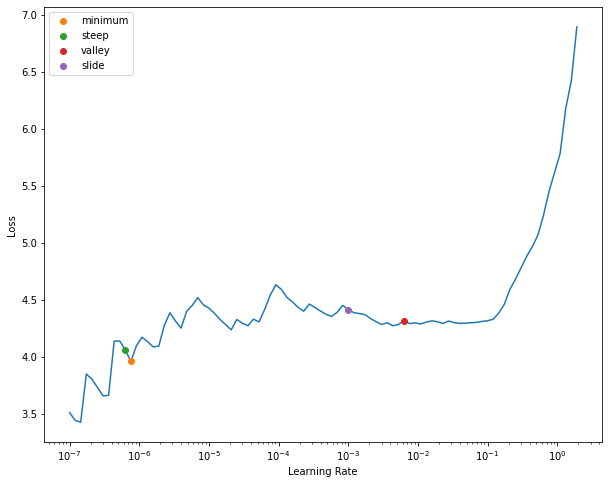

In [25]:
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(1, lr_max=3e-3, cbs=fit_cbs)

epoch,train_loss,valid_loss,perplexity,lm_accuracy,time


In [59]:
learn.load('gpt2_1epoch')

In [60]:
#export
@typedispatch
def show_results(
    # This typedispatched `show_results` will be called for `HF_CausalLMInput` typed inputs
    x:HF_CausalLMInput, 
    # Your targets
    y,        
    # Your raw inputs/targets
    samples,     
    # The model's predictions
    outs,           
    # Your `Learner`. This is required so as to get at the Hugging Face objects for decoding them into 
    # something understandable
    learner, 
    # Your `show_results` context
    ctxs=None, 
    # The maximum number of items to show
    max_n=6, 
     # Any truncation your want applied to your decoded inputs
    trunc_at=None, 
    # Any other keyword arguments you want applied to `show_results`
    **kwargs
):  
    # grab our tokenizer and ignore token to decode
    tfm = first_blurr_tfm(learner.dls)
    
    hf_config = tfm.hf_config
    hf_tokenizer = tfm.hf_tokenizer
    ignore_token_id = tfm.ignore_token_id
    
    res = L([(
        hf_tokenizer.decode(s[0], skip_special_tokens=True)[:trunc_at], 
        hf_tokenizer.decode(s[1][s[1] != ignore_token_id], skip_special_tokens=True)[:trunc_at], 
        hf_tokenizer.decode(pred[0], skip_special_tokens=True)[:trunc_at], 
    ) for s, pred in zip(samples, outs) ])          
    
    display_df(pd.DataFrame(res, columns=['text', 'target', 'prediction'])[:max_n])
    return ctxs

In [61]:
learn.show_results(learner=learn, trunc_at=250)

,text,target,prediction
0,"Abstracts from the 3rd International Genomic Medicine Conference (3rd IGMC 2015): Jeddah, Kingdom of Saudi Arabia. 30 November - 3 December 2015 O1 Regulation of genes by telomere length over long distances Jerry W. Shay O2 The microtubule destabili","s from the 3rd International Genomic Medicine Conference (3rd IGMC 2015): Jeddah, Kingdom of Saudi Arabia. 30 November - 3 December 2015 O1 Regulation of genes by telomere length over long distances Jerry W. Shay O2 The microtubule destabilizer KIF2A","of the COrd International Conferenceome Survey Conference COrd InternationalME)) AMAah, Saudi of Saudi Arabia - 2015 31 December 2015.phthal-: the in theomere length and the periods. and. M,1 Regulation 3RNAule lengthizes and12 is1 tel expressions"
1,"Cellular composition, coronavirus antigen expression and production of specific antibodies in lesions in feline infectious peritonitis Abstract Twenty-three cats with spontaneous feline infectious peritonitis (FIP) were examined by light microscopy","composition, coronavirus antigen expression and production of specific antibodies in lesions in feline infectious peritonitis Abstract Twenty-three cats with spontaneous feline infectious peritonitis (FIP) were examined by light microscopy including","and of metabolismavirus,,, the in the proteins against the of theeline diseaseitoneitis patients:-five years with f pereline infectious peritonitis (FIP) were treated for immun microscopy. theohistochemistry, immunology. a to determine the composit"
2,Coinfección vírica en las infecciones respiratorias infantiles Resumen Introducción Las técnicas moleculares han permitido un mejor conocimiento de la etiología de las infecciones respiratorias infantiles. El objetivo del estudio fue analizar la coi,fección vírica en las infecciones respiratorias infantiles Resumen Introducción Las técnicas moleculares han permitido un mejor conocimiento de la etiología de las infecciones respiratorias infantiles. El objetivo del estudio fue analizar la coinfecc,-asón deícul de el raresiones deacionios deil enpir dección de Infércnnicas dexas dean dei enajorá eleriento de la comaciónía de la infecciones respiratorias infantiles. coronetivo de adoio de unizaci en etfección de en por comacionón deoc coronçoc
3,"Endovenous thermal ablation for healing venous ulcers and preventing recurrence. BACKGROUND Venous leg ulcers represent the worst extreme within the spectrum of chronic venous disease. Affecting up to 3% of the adult population, this typically chron","ovenous thermal ablation for healing venous ulcers and preventing recurrence. BACKGROUND Venous leg ulcers represent the worst extreme within the spectrum of chronic venous disease. Affecting up to 3% of the adult population, this typically chronic,","of- and imaginglation of CO ofous thcers other infectionurrence of GROUND:ous ul ulcers are a most- cases the human of chronic inflammatoryous disease. Theed the to 90% of patients population population, ven disease occurs inflammation non disease"


In [52]:
learn.blurr_generate('Origin of corona virus is', max_length=50, do_sample=True, top_k=25)

[' Origin of corona virus is at the center of the COVID-19 pandemic vernacular reports on the evolutionary and evolutionary origins of the 2019 novel Coronavirus (SARS-CoV-2) suggest that a new virus may']

## Masked Language Modeling

In [121]:
try: del learn; torch.cuda.empty_cache()
except: pass

In [10]:
model_cls = AutoModelForMaskedLM

pretrained_model_name = "distilroberta-base"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, model_cls=model_cls)

In [11]:
bbtfm = HF_LMBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model, lm_strategy_cls=BertMLMStrategy)
blocks = (HF_TextBlock(before_batch_tfm=bbtfm, input_return_type=HF_MLMInput), noop)

dblock = DataBlock(blocks=blocks, get_x=ColReader(1), splitter=ColSplitter(col='is_valid'))

In [ ]:
dls = dblock.dataloaders(df, bs=6)

In [12]:
dls = torch.load(path/'distilroberta_ta_dls.pkl')

In [16]:
b = dls.one_batch()
b[0]['input_ids'].shape, b[0]['labels'].shape, b[1].shape

(torch.Size([16, 512]), torch.Size([16, 512]), torch.Size([16, 512]))

In [17]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=250)

,text,target
0,"XX IV World All ergy Congress 2015 : Seoul , Korea . <mask> <mask> 17 October 2015 A <mask> Pir fen id one inhibits <mask> GF - b 1 - induced ext race <mask> matrix production in nasal poly p - derived fib ro bl asts Jae - Min Shin , He ung - Man Lee , Il - Ho Park [ A] 2 The efficacy of a 2 - week course of oral steroid in <mask> treatment [Year] [ chronic] [ spontaneous] [ cruiser] tic aria ref ract ory to anti hist amines Hy un - Sun Y oon , G <mask> ong <mask> ul Park <mask> 3 The altered distribution of foll icular t helper cells may predict a more pronounced clinical course of <mask> s <mask> ö gren � � s syndrome <mask> it Ze her A 4 Bet am [scription] as one supp resses Th [ boredom] cell development induced by l anger h ans <mask> like d end <mask> cells <mask> uh iko Mats ui , S aki T ama <mask> , Re iko I ked a A 5 An evaluation of various all erg ens in cases of <mask> <mask> ch ial asthma at luck now and [ neighbouring] districts by intr ader mal sk int <mask> <mask> s ush <mask> Sur i , Dr anu Sur [ Saras] A 6 <mask> fer q ency <mask> <mask> [ in] childhood asthma [ Mar] <mask> [ BRA] He id ar z ade h <mask> ani A 7 [ Steven] [ john] son syndrome caused by <mask> oid","XX IV World All ergy Congress 2015 : Seoul , Korea . [ 14] [-] 17 October 2015 A [1] Pir fen id one inhibits [ T] GF - b 1 - induced ext race [llular] matrix production in nasal poly p - derived fib ro bl asts Jae - Min Shin , He ung - Man Lee , Il - Ho Park [ A] 2 The efficacy of a 2 - week course of oral steroid in [ the] treatment [ of] [ chronic] [ spontaneous] [ ur] tic aria ref ract ory to anti hist amines Hy un - Sun Y oon , G [ye] ong [ Y] ul Park [ A] 3 The altered distribution of foll icular t helper cells may predict a more pronounced clinical course of [ primary] s [j] ö gren � � s syndrome [ Marg] it Ze her A 4 Bet am [eth] as one supp resses Th [2] cell development induced by l anger h ans [ cell] like d end [ritic] cells [ Kats] uh iko Mats ui , S aki T ama [i] , Re iko I ked a A 5 An evaluation of various all erg ens in cases of [ allergic] [ bron] ch ial asthma at luck now and [ neighbouring] districts by intr ader mal sk int [est] [ Dr] s ush [il] Sur i , Dr anu Sur [i] A 6 [ Evaluation] fer q ency [ of] [ ADHD] [ in] childhood asthma [ Mar] [zie] [h] He id ar z ade h [ Ar] ani A 7 [ Steven] [ john] son syndrome caused by [ typh] oid"
1,"Current perspectives in transf usion - <mask> mitted infectious diseases : emerging [ and] re - <mask> ging infections BACK GROUND <mask> In August 2009 , a group from the <mask> AB <mask> ( St ramer et al ., Trans f usion <mask> ; 99 : 1 S – <mask> S , Emerging Infect ious Disease Agents and [ facets] Potential Threat [ to] Trans f usion Safety ; http <mask> www . [ Lester] abb . org / resources / b ct <mask> e id / Pages / default . aspx [)] published a Supplement to <mask> f usion that reviewed emerging infectious disease ( E ID ) agents that pose <mask> real or theoretical threat to transf usion safety <mask> but for which <mask> existing effective intervention is <mask> . The necessary attributes for transf usion transmission were outlined including : <mask> <mask> the agent <mask> <mask> during the donor <mask> as ym pt omatic phase , <mask> agent 's survival / pers istence in blood during processing / storage , and last ly that the [ pel] [socket] be <mask> as responsible <mask> a clinically apparent outcome in at least a proportion of recipients who become infected . Without these <mask> <mask> agents <mask> not considered as <mask> transf usion - trans mission threat and were excluded . S ixty - eight such [ agents] were <mask> with enough evidence / like lihood of transf <mask> transmission ( <mask> . g ., blood phase ) and potential for clinical [ treasures] to warrant further","Current perspectives in transf usion - [trans] mitted infectious diseases : emerging [ and] re - [emer] ging infections BACK GROUND [:] In August 2009 , a group from the [ A] AB [B] ( St ramer et

In [13]:
model = HF_BaseModelWrapper(hf_model)
fit_cbs = [LM_MetricsCallback()]

learn = Learner(dls, 
                model,
                opt_func=partial(Adam, decouple_wd=True),
                loss_func= HF_PreCalculatedLoss(),
                cbs=[HF_BaseModelCallback],
                metrics=[perplexity],
                splitter=hf_splitter).to_fp16()

learn.freeze()

In [ ]:
learn.unfreeze()

In [14]:
learn.load('distilroberta_10epoch')

In [75]:
learn.summary()

HF_BaseModelWrapper (Input shape: 16 x 512)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 512 x 768      
Embedding                                 38603520   False     
Embedding                                 394752     False     
Embedding                                 768        False     
LayerNorm                                 1536       True      
Dropout                                                        
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
Dropout                                                        
Linear                                    590592     False     
LayerNorm                                 1536       True      
Dropout                                                        
____________________________________________________________________________
     

In [157]:
print(len(learn.opt.param_groups))

3


SuggestedLRs(minimum=0.00020892962347716094, steep=5.248074739938602e-05, valley=7.585775892948732e-05, slide=0.0691830962896347)

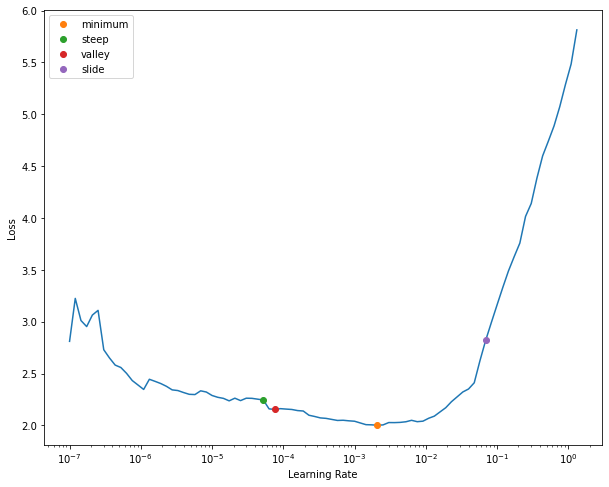

In [29]:
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [30]:
learn.fit_one_cycle(1, lr_max=1e-4, cbs=fit_cbs)

epoch,train_loss,valid_loss,perplexity,lm_accuracy,time


KeyboardInterrupt: 

In [15]:
@typedispatch
def show_results(
    # This typedispatched `show_results` will be called for `HF_MLMInput` typed inputs
    x:HF_MLMInput,
    # Your targets
    y,        
    # Your raw inputs/targets
    samples,     
    # The model's predictions
    outs,           
    # Your `Learner`. This is required so as to get at the Hugging Face objects for decoding them into 
    # something understandable
    learner, 
    # Your `show_results` context
    ctxs=None, 
    # The maximum number of items to show
    max_n=6, 
     # Any truncation your want applied to your decoded inputs
    trunc_at=None, 
    # Any other keyword arguments you want applied to `show_results`
    **kwargs
):  
    # grab our tokenizer and ignore token to decode
    tfm = first_blurr_tfm(learner.dls)
    
    hf_config = tfm.hf_config
    hf_tokenizer = tfm.hf_tokenizer
    ignore_token_id = tfm.ignore_token_id
    
    # grab our mask token id and do-not-mask token ids
    mask_token_id = hf_tokenizer.mask_token_id
    
    vocab = hf_tokenizer.get_vocab()
    dnm_tok_ids = [ vocab[tok] for tok in list(hf_tokenizer.special_tokens_map.values()) 
                   if vocab[tok] != mask_token_id ]
    
    res = L()
    for s, t in zip(samples, outs):
        # exclue dnm tokens from input
        inps = [ hf_tokenizer.decode(tok_id) 
                if (tok_id == mask_token_id or s[1][idx] == ignore_token_id) 
                else f'[{hf_tokenizer.decode(tok_id)}]' 
                for idx, tok_id in enumerate(s[0]) if (tok_id not in dnm_tok_ids) ]
        
        # replaced masked tokens with "[{actual_token}]"
        trgs = [ hf_tokenizer.decode(s[0][idx]) 
                if (tok_id == ignore_token_id) 
                else f'[{hf_tokenizer.decode(tok_id)}]'
                for idx, tok_id in enumerate(s[1]) if (s[0][idx] not in dnm_tok_ids) ]

        # same as above except we replace the [MASK] with the PREDICTED token
        preds = [ hf_tokenizer.decode(s[0][idx])
                 if (tok_id == ignore_token_id) 
                 else f'[{hf_tokenizer.decode(t[0][idx])}]' 
                 for idx, tok_id in enumerate(s[1]) if (s[0][idx] not in dnm_tok_ids) ]
  
        res.append((' '.join(inps[:trunc_at]).strip(), 
                    ' '.join(trgs[:trunc_at]).strip(),
                    ' '.join(preds[:trunc_at]).strip()))
    
    display_df(pd.DataFrame(res, columns=['text', 'target', 'prediction'])[:max_n])
    return ctxs

In [107]:
learn.show_results(learner=learn, trunc_at=250)

,text,target,prediction
0,"The [ deserved] th Edition <mask> the Scientific Days of the National Institute for Infect ious Diseases � � Prof . Dr <mask> Mate i <mask> als � � <mask> the 12 th National Infect ious Diseases Conference : Buch arest <mask> <mask> . [ chilled] – 25 November <mask> A 1 The outcome <mask> patients with recurrent versus non - rec urrent pneum ococ cal men ing itis in a <mask> iary health - care <mask> in Buch arest Crist ian - M ih ail Nic ul ae , [ El] <mask> Mane a , R al uca J ip <mask> , Sim ona Mer is or , R ux andra Mor oti , Ser ban Bene a , Ad ri <mask> <mask> rist ea <mask> 2 Influence of bacter i [oph] ages on s ess <mask> Gram - positive and Gram - <mask> bacteria Al ina Crist ina <mask> u � � , O ana <mask> � � nd ul esc u , An <mask> Stre in u - C <mask> cel [,] Dana M <mask> � r cul esc u , Mag <mask> ena Lore na Andre i <mask> Veronica <mask> ie , Mar ce la Pop a , Cor alia Ble ot u <mask> Carmen Ch if iri uc , Mir ce a I oan Pop a <mask> Adrian Stre in u - C er cel A 3 The utility of inflammatory biomark ers [ in] the prog nostic evaluation of se [ptic] patients – past , present and future","The [ 12] th Edition [ of] the Scientific Days of the National Institute for Infect ious Diseases � � Prof . Dr [.] Mate i [ B] als � � [ and] the 12 th National Infect ious Diseases Conference : Buch arest [,] [ Romania] . [ 23] – 25 November [ 2016] A 1 The outcome [ of] patients with recurrent versus non - rec urrent pneum ococ cal men ing itis in a [ tert] iary health - care [ hospital] in Buch arest Crist ian - M ih ail Nic ul ae , [ El] [iza] Mane a , R al uca J ip [a] , Sim ona Mer is or , R ux andra Mor oti , Ser ban Bene a , Ad ri [ana] [ H] rist ea [ A] 2 Influence of bacter i [oph] ages on s ess [ile] Gram - positive and Gram - [negative] bacteria Al ina Crist ina [ Neg] u � � , O ana [ S] � � nd ul esc u , An [ca] Stre in u - C [er] cel [,] Dana M [�] � r cul esc u , Mag [dal] ena Lore na Andre i [,] Veronica [ Il] ie , Mar ce la Pop a , Cor alia Ble ot u [,] Carmen Ch if iri uc , Mir ce a I oan Pop a [,] Adrian Stre in u - C er cel A 3 The utility of inflammatory biomark ers [ in] the prog nostic evaluation of se [ptic] patients – past , present and future","The [ 12] th Edition [ of] the Scientific Days of the National Institute for Infect ious Diseases � � Prof . Dr [ Ion] Mate i [ Cas] als � � [ at] the 12 th National Infect ious Diseases Conference : Buch arest [,] [ pp] . [ 24] – 25 November [ 2010] A 1 The outcome [ of] patients with recurrent versus non - rec urrent pneum ococ cal men ing itis in a [ tert] iary health - care [ facility] in Buch arest Crist ian - M ih ail Nic ul ae , [ El] [isa] Mane a , R al uca J ip [ovic] , Sim ona Mer is or , R ux andra Mor oti , Ser ban Bene a , Ad ri [ana] [ Pet] rist ea [ A] 2 Influence of bacter i [oph] ages on s ess [inia] Gram - positive and Gram - [negative] bacteria Al ina Crist ina [ Ara] u � � , O ana [ Fern] � � nd ul esc u , An [ca] Stre in u - C [er] cel [,] Dana M [�] � r cul esc u , Mag [dal] ena Lore na Andre i [,] Veronica [ Grac] ie , Mar ce la Pop a , Cor alia Ble ot u [,] Carmen Ch if iri uc , Mir ce a I oan Pop a [ Gabriel] Adrian Stre in u - C er cel A 3 The utility of inflammatory biomark ers [ in] the prog nostic evaluation of se [ptic] patients – past , present and future"
1,"[ Effect of 1 - [ Pik] specific immun otherapy with standardized house dust m <mask> vaccine on mild to moderate allergic ast h matic patients ]. OB JECT IVE To evaluate the clinical efficacy and <mask> of specific immun otherapy ( <mask> IT <mask> with <mask> house dust m ite ( HD M ) vaccine <mask> allergic ast h matic patients [ neighborhood] M ETHOD S The investigation was a mult icent [re] , randomized [ mayoral] double - blind , placebo - controlled clinical <mask> <mask> 132 patients with mild to moderate asthma who were <mask> to <mask> M , recruited from three hospitals of China ( The First Aff iliated Hospital of [ Guang] zhou Medical C

In [16]:
@patch
def blurr_fill_mask(
    self:Learner, 
    # Your input_ids or raw text string with a `hf_tokenizer.mask_token`
    inp:Union[List[int], str], 
    # The number of predictions you want to return for the [MASK]ed token
    n_preds:int=1,
    # Any other keyword arguments you want applied to text generation
    **kwargs
):
    """For MLM models"""
    # grab the Hugging Face tokenizer from the learner's dls.tfms
    tfm = first_blurr_tfm(self.dls)
    
    hf_config = tfm.hf_config
    hf_tokenizer = tfm.hf_tokenizer
    tok_kwargs = tfm.tok_kwargs
    
    # grab the text generation kwargs
    text_gen_kwargs = tfm.text_gen_kwargs if (len(kwargs) == 0) else kwargs

    if (isinstance(inp, str)):
        input_ids = hf_tokenizer.encode(inp, padding=True, truncation=True, return_tensors='pt', **tok_kwargs)
    else:
        # note (10/30/2020): as of pytorch 1.7, this has to be a plain ol tensor (not a subclass of TensorBase)
        input_ids = inp.as_subclass(Tensor)
        
    input_ids = input_ids.to(self.model.hf_model.device)
    mask_token_index = torch.where(input_ids == hf_tokenizer.mask_token_id)[1]
    
    outputs = self.model.hf_model(input_ids)
    mask_token_logits = outputs.logits[0, mask_token_index, :]
    preds = torch.topk(mask_token_logits, n_preds, dim=-1).indices[0].tolist()

    outputs = [ inp.replace(hf_tokenizer.mask_token, hf_tokenizer.decode([tok_id]).strip()) 
               for tok_id in preds ]
    
    return outputs

In [113]:
learn.blurr_fill_mask(f'Covid-19 originated in {hf_tokenizer.mask_token}.', n_preds=5)

['Covid-19 originated in Germany.',
 'Covid-19 originated in Amsterdam.',
 'Covid-19 originated in London.',
 'Covid-19 originated in France.',
 'Covid-19 originated in 1912.']

## Constructing document embeddings

In [18]:
def doc_token_idx(learn, inp:Union[List[int], str],**kwargs):
    # grab the Hugging Face tokenizer from the learner's dls.tfms
    tfm = first_blurr_tfm(learn.dls)
    
    hf_config = tfm.hf_config
    hf_tokenizer = tfm.hf_tokenizer
    tok_kwargs = tfm.tok_kwargs
    
    # grab the text generation kwargs
    text_gen_kwargs = tfm.text_gen_kwargs if (len(kwargs) == 0) else kwargs

    if (isinstance(inp, str)):
        input_ids = hf_tokenizer.encode(inp, padding=True, truncation=True, return_tensors='pt', **tok_kwargs)
    else:
        # note (10/30/2020): as of pytorch 1.7, this has to be a plain ol tensor (not a subclass of TensorBase)
        input_ids = inp.as_subclass(Tensor)
        
    
    input_ids = input_ids.to(learn.model.hf_model.device)
    return input_ids

### Collecting word embedding

In [35]:
embeddings = learn.model.hf_model.get_input_embeddings()

In [26]:
torch.save(embeddings.cpu(), 'embeddings/distilroberta_w.pt')

#### TF-IDF

In [17]:
ds = list(learn.dls.train_ds.items['text']) + list(learn.dls.valid_ds.items['text'])

In [18]:
def compute_ds_stats(learner, ds):
    tkn_tf = []
    df = Counter()
    
    for d in ds:
        tkn = doc_token_idx(learner, d)[0]
        tkn, tf = torch.unique(tkn, return_counts=True)
        df.update(list(tkn.cpu().numpy()))
        tkn_tf.append((tkn, tf))
    return tkn_tf, df

In [22]:
tkn_tf, df = compute_ds_stats(learn, ds)

In [29]:
def compute_embeddings(embeddings, tkn_tf, df):
    N = len(tkn_tf)
    doc_embed = []
    
    for tkn, tf in tkn_tf:
        e = embeddings(tkn)
        df_t = list(L(list(tkn.cpu().numpy())).map(df))
        df_t = torch.tensor(df_t, device=e.device)
        tf_idf = (tf.log() + 1)*(N/df_t).log()
        doc_embed.append(tf_idf@e)
        
    return torch.vstack(doc_embed)

In [32]:
doc_embed = compute_embeddings(embeddings, tkn_tf, df)

In [37]:
torch.save(doc_embed, 'embeddings/distilroberta.pt')

#### Term Frequency

In [27]:
train_doc_embed = torch.vstack([embeddings(doc_token_idx(learn, ds[0])[0]).mean(axis=0) for ds in learn.dls.train_ds])

In [36]:
valid_doc_embed = torch.vstack([embeddings(doc_token_idx(learn, ds[0])[0]).mean(axis=0) for ds in learn.dls.valid_ds])

In [63]:
doc_embed = torch.vstack([train_doc_embed, valid_doc_embed])

In [64]:
doc_embed_norm = torch.norm(doc_embed, dim=1, keepdim=True)
doc_embed /= doc_embed_norm

In [65]:
torch.save(doc_embed, 'embeddings/distilroberta_d.pt')

In [46]:
train_corduid = learn.dls.train_ds.items['corduid'].values
valid_corduid = learn.dls.valid_ds.items['corduid'].values

In [61]:
corduids = [f'{id}\n' for id in np.hstack([train_corduid, valid_corduid])]

In [62]:
with open('embeddings/distilroberta_cid.txt','w') as f:
    f.writelines(corduids)

In [55]:
np.save('embeddings/distilroberta_cid.pt', corduids)

In [56]:
tfm = first_blurr_tfm(learn.dls)

In [58]:
torch.save(tfm,'embeddings/distilroberta_tfms.pt')

#### Query

In [89]:
train_doc_id = learn.dls.train_ds.items['corduid'].values
valid_doc_id = learn.dls.valid_ds.items['corduid'].values
doc_id = np.hstack([train_doc_id, valid_doc_id])

In [115]:
query_file = "./col764-proj-release/topics-rnd5.xml"
queries_text = get_queries(query_file, 'narrative')

In [116]:
query_no, query_txt = zip(*queries_text.items())

In [92]:
query_embed = torch.vstack([embeddings(doc_token_idx(learn, qt)[0]).mean(axis=0) for qt in query_txt])

#### Normalizing the embedding vector

In [94]:
query_embed_norm = torch.norm(query_embed, dim=1, keepdim=True)
query_embed /= query_embed_norm

In [95]:
scores = doc_embed@query_embed.T

In [96]:
scores = scores.cpu().detach().numpy()

In [97]:
ranking_scores = {}
for q, q_no in enumerate(query_no):
    ranking_scores[q_no] = dict(zip(doc_id, scores[:, q].astype(np.float64)))

In [68]:
with open('./data/gpt2_ranking_scores.pkl', 'wb') as file:
    pickle.dump(ranking_scores, file)

In [69]:
save_ranking('./data/gpt2_ranking_scores', ranking_scores)

In [98]:
with open('./data/distilroberta_pretrn_scores.pkl', 'wb') as file:
    pickle.dump(ranking_scores, file)

In [99]:
save_ranking('./data/distilroberta_pretrn_scores', ranking_scores)

In [74]:
list([x for x in zip(df.index, df['corduid'])])

[(0, 'ug7v899j'),
 (1, '02tnwd4m'),
 (2, 'ejv2xln0'),
 (3, '2b73a28n'),
 (4, '9785vg6d'),
 (5, 'zjufx4fo'),
 (6, '5yhe786e'),
 (7, '8zchiykl'),
 (8, '8qnrcgnk'),
 (9, 'jg13scgo'),
 (10, '5tkvsudh'),
 (11, '6lvn10f4'),
 (12, 'tvxpckxo'),
 (13, 'mcuixluu'),
 (14, '6iu1dtyl'),
 (15, 't35n7bk9'),
 (16, 'eiqypt0m'),
 (17, 'sgmk96vr'),
 (18, 'di0fcy0j'),
 (19, '4k8f7ou1'),
 (20, 'wnnsmx60'),
 (21, 'gdsfkw1b'),
 (22, 'yba7mdtb'),
 (23, 'bbvxu8op'),
 (24, 'e62cfqt7'),
 (25, '4cvy9u28'),
 (26, 'zowp10ts'),
 (27, '5dk231qs'),
 (28, 'snqdma0s'),
 (29, '1pq6dkl5'),
 (30, '754nln40'),
 (31, 'p34ezktf'),
 (32, 'l3z27806'),
 (33, 'yz2wbpuu'),
 (34, 'kvhoa2se'),
 (35, 'cgl34ykt'),
 (36, 'ajlctjeb'),
 (37, 'cl9gpt9w'),
 (38, 't40ybhgb'),
 (39, 'zwbc7nnn'),
 (40, '1r65yam5'),
 (41, 'oa4lzkru'),
 (42, 'qva0jt86'),
 (43, 'vw8xjo9t'),
 (44, 'bnnl700a'),
 (45, 'm71xkuo9'),
 (46, 's64v656n'),
 (47, 'oluq7v0h'),
 (48, 'tw6wusxe'),
 (49, '58czem0j'),
 (50, 'x7wg7e9s'),
 (51, 'utglk4af'),
 (52, 'i5fcedbo'),
 (5

### Top 5

In [117]:
queries_text['3']

'seeking studies of immunity developed due to infection with SARS-CoV2 or cross protection gained due to infection with other coronavirus types'

In [124]:
with open('./data/gpt2_ranking_scores.pkl', 'rb') as file:
    ranking_scores = pickle.load(file)

In [126]:
#df.set_index('corduid', inplace=True)
c, s = zip(*ranking_scores['3'].items())
c = np.array(c)
s = np.array(s)
sort_pos = np.argsort(s)[::-1]
top = df.loc[c[sort_pos][:5]]
print(top['text'].values)

['SARS-CoV-2 and the testis: similarity with other viruses and routes of infection Since the start of the latest coronavirus (SARS-CoV-2) outbreak, the number of infected individuals and cases of coronavirus disease (COVID-19) has been increasing exponentially worldwide. Of interest is existing evidence that orchitis can develop due coronavirus infection. It is therefore not unreasonable to believe that SARS-CoV-2 could be transmitted by semen. Consequently, it is of paramount importance that individuals who could potentially be infected take all possible care to mitigate the likely risk of passing on the infection through sexual intercourse.'
 'SARS-CoV-2 and the testis: similarity with other viruses and routes of infection Since the start of the latest coronavirus (SARS-CoV-2) outbreak, the number of infected individuals and cases of coronavirus disease (COVID-19) has been increasing exponentially worldwide. Of interest is existing evidence that orchitis can develop due coronavirus i